In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./data/Crop_recommendation.csv")
df.head(n=2)

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice


In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Scaling X
for col in X.columns:
    col_max = X[col].abs().max()
    print(col_max)
    X[col] /= col_max

# Label Encoding y
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

140
145
205
43.67549305
99.98187601
9.93509073
298.5601175


In [5]:
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [6]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
torch.cuda.empty_cache()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5, shuffle=True)

In [8]:
class ClassificationDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.tensor(np.array(X), dtype=torch.float32).to(device)
        self.y = torch.tensor(np.array(y).reshape(-1), dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
train = ClassificationDataset(X_train, y_train)
val = ClassificationDataset(X_val, y_val)
test = ClassificationDataset(X_test, y_test)

In [10]:
train_dataloader = DataLoader(train)
val_dataloader = DataLoader(val)
test_dataloader = DataLoader(test)

In [11]:
HIDDEN_NEURONS = 10
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        self.hidden_layer = nn.Linear(HIDDEN_NEURONS, HIDDEN_NEURONS)  
        self.output = nn.Linear(HIDDEN_NEURONS, len(np.unique(y)))  

        self.relu = nn.ReLU()  # ReLU for hidden layers
        self.softmax = nn.Softmax(dim=1)  # Softmax for multi-class classification

    def forward(self, x):
        x = self.relu(self.input_layer(x))
        x = self.relu(self.hidden_layer(x))
        x = self.output(x)
        x = self.softmax(x)

        return x

In [12]:
model = Model().to(device)
from torchsummary import summary

summary(model, (X.shape[1], ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              80
              ReLU-2                   [-1, 10]               0
            Linear-3                   [-1, 10]             110
              ReLU-4                   [-1, 10]               0
            Linear-5                   [-1, 22]             242
           Softmax-6                   [-1, 22]               0
Total params: 432
Trainable params: 432
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [13]:
BATCH_SIZE = 32
EPOCHS = 100
HIDDEN_NEURONS = 10
LR = 1e-3

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [15]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    ## Training Loop
    for data in train_dataloader:
        inputs, labels = data
        labels = labels.long() 
        prediction = model(inputs)  # No squeeze
        batch_loss = criterion(prediction, labels)
        total_loss_train += batch_loss.item()

        acc = (prediction.argmax(dim=1) == labels).sum().item()  # Corrected accuracy
        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    ## Validation Loop
    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data
            labels = labels.long()
            prediction = model(inputs)  # No squeeze
            batch_loss = criterion(prediction, labels)
            total_loss_val += batch_loss.item()

            acc = (prediction.argmax(dim=1) == labels).sum().item()  # Corrected accuracy
            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(train.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(val.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(train.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(val.__len__())*100):.4f}''')
    print("="*50)


Epoch no. 1 Train Loss: 4.7531 Train Accuracy: 6.4286 Validation Loss: 1.0157 Validation Accuracy: 8.7879
Epoch no. 2 Train Loss: 4.6838 Train Accuracy: 10.9740 Validation Loss: 0.9923 Validation Accuracy: 13.6364
Epoch no. 3 Train Loss: 4.5891 Train Accuracy: 16.2987 Validation Loss: 0.9768 Validation Accuracy: 23.6364
Epoch no. 4 Train Loss: 4.4987 Train Accuracy: 26.9481 Validation Loss: 0.9578 Validation Accuracy: 29.6970
Epoch no. 5 Train Loss: 4.4081 Train Accuracy: 35.4545 Validation Loss: 0.9389 Validation Accuracy: 39.6970
Epoch no. 6 Train Loss: 4.3319 Train Accuracy: 42.7922 Validation Loss: 0.9241 Validation Accuracy: 44.5455
Epoch no. 7 Train Loss: 4.2666 Train Accuracy: 49.1558 Validation Loss: 0.9086 Validation Accuracy: 51.8182
Epoch no. 8 Train Loss: 4.2011 Train Accuracy: 55.3896 Validation Loss: 0.8947 Validation Accuracy: 56.9697
Epoch no. 9 Train Loss: 4.1443 Train Accuracy: 57.4675 Validation Loss: 0.8825 Validation Accuracy: 59.0909
Epoch no. 10 Train Loss: 4.090

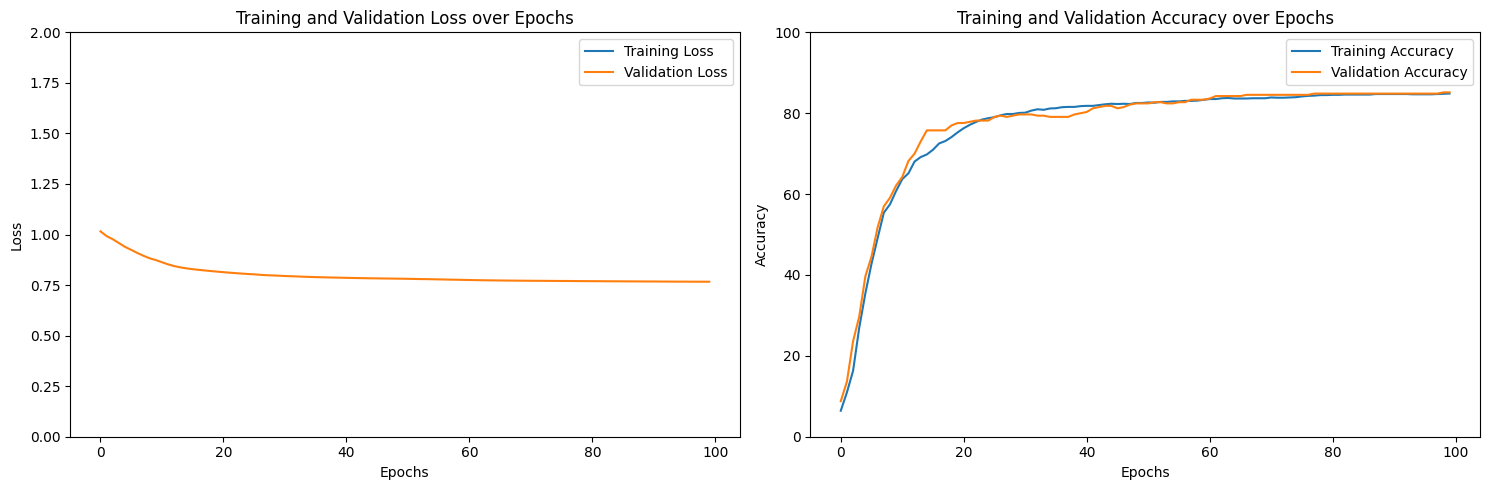

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

In [17]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in test_dataloader:
    inputs, labels = data
    labels = labels.long()
    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion((prediction), labels)
    total_loss_test += batch_loss_test.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")
     

Accuracy Score is: 86.97%


In [18]:
torch.save(model.state_dict(), "./models/tabular_sowing_classification.pt")

In [19]:
model = model.load_state_dict(torch.load("./models/tabular_sowing_classification.pt"))